In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle

sys.path.insert(0, "/home/masonbp/code/robotdatapy")
from robotdatapy import transform
import robotdatapy as rdp

In [7]:
robot1 = 'sparkal1'
robot2 = 'sparkal2'

g2o_odom_1 = f"/home/masonbp/results/segment_track/rgbd18/g2o/{robot1}.g2o"
g2o_odom_2 = f"/home/masonbp/results/segment_track/rgbd18/g2o/{robot2}.g2o"
pkl_odom_1 = f"/home/masonbp/results/segment_track/rgbd18/{robot1}.pkl"
pkl_odom_2 = f"/home/masonbp/results/segment_track/rgbd18/{robot2}.pkl"
g2o_lc = f"/home/masonbp/results/submap_align/kmd_outdoor/rgbd18/{robot1}_{robot2}/05_g2o.g2o"

In [8]:
def parse_g2o_odom(file):
    
    with open(file, 'r') as f:
        lines = f.readlines()
        
    poses = [rdp.transform.T_FLURDF]
    
    for line in lines:
        data = line.strip().split()
        if data[0] == 'EDGE_SE3:QUAT':
            assert int(data[1]) == len(poses) - 1, (data[1], len(poses))
            assert int(data[2]) == len(poses), (data[2], len(poses))
            T = rdp.transform.xyz_quat_to_transform(data[3:6], data[6:10])
            poses.append(poses[-1] @ T)
            
    # for i in range(len(poses)):
    #     poses[i] = poses[i] @ rdp.transform.T_FLURDF
    return poses

def parse_g2o_lc(file, req_assoc_cnt=0):

    idxs1 = []
    idxs2 = []

    with open(file, 'r') as f:
        lines = f.readlines()
        current_num_assoc_cnt = 0
        for line in lines:
            data = line.strip().split()
            if data[0] == '#' and data[1] == 'LC:':
                current_num_assoc_cnt = int(data[2])
            if data[0] == 'EDGE_SE3:QUAT':
                if current_num_assoc_cnt < req_assoc_cnt:
                    continue
                idxs1.append(int(data[1][1:]))
                idxs2.append(int(data[2][1:]))

    return idxs1, idxs2

def pkl_to_poses(file):
    with open(os.path.expanduser(file), 'rb') as f:
        pickle_data = pickle.load(f)
        if len(pickle_data) == 2:
            _, poses, = pickle_data
        else:
            _, poses, _ = pickle_data
    return poses

In [9]:
# poses_1 = parse_g2o_odom(g2o_odom_1)
# poses_2 = parse_g2o_odom(g2o_odom_2)
poses_1 = pkl_to_poses(pkl_odom_1)
poses_2 = pkl_to_poses(pkl_odom_2)
lcs1, lcs2 = parse_g2o_lc(g2o_lc, req_assoc_cnt=5)

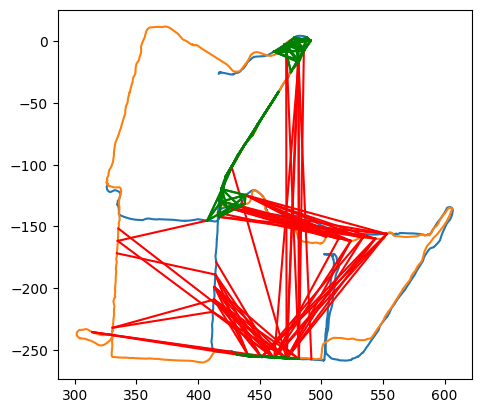

In [13]:
fig, ax = plt.subplots()

ax.plot([p[0, 3] for p in poses_1], [p[1, 3] for p in poses_1], label='odom 1')
ax.plot([p[0, 3] for p in poses_2], [p[1, 3] for p in poses_2], label='odom 2')
for k in range(2):
    for i, j in zip(lcs1, lcs2):
        lc_length = np.linalg.norm(poses_1[i][0:2, 3] - poses_2[j][0:2, 3])
        if lc_length > 30:
            if k == 1:
                continue
            color = 'r'
        else:
            color = 'g'
        ax.plot([poses_1[i][0, 3], poses_2[j][0, 3]], [poses_1[i][1, 3], poses_2[j][1, 3]], color)
ax.set_aspect('equal')